In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import matplotlib
matplotlib.rc('font', family='AppleGothic')
matplotlib.rc('axes', unicode_minus=False)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# 그래프 틀 변경
plt.rcParams['axes.unicode_minus'] = False
sns.set(font_scale = 1)  
plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_columns', None)

# 한글폰트 사용
import os

if os.name == 'posix':

    plt.rc("font", family="AppleGothic")
else :

    plt.rc("font", family="Malgun Gothic")

In [3]:
from tqdm import tqdm
import torch
from torch import nn, optim

In [4]:
data = pd.read_csv('Data/covid_data.csv', index_col = 0)
data.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황,년,월,일,주,거리두기
76,324,8816,2020-03-21,서초구,-,감염경로 조사중,퇴원,2020,3,21,12,0.0
77,323,8826,2020-03-21,서대문구,-,감염경로 조사중,퇴원,2020,3,21,12,0.0
78,322,8881,2020-03-21,서대문구,유럽,해외유입,퇴원,2020,3,21,12,0.0
79,321,8836,2020-03-21,영등포구,유럽,해외유입,퇴원,2020,3,21,12,0.0
80,320,8848,2020-03-21,성동구,-,감염경로 조사중,퇴원,2020,3,21,12,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203100 entries, 76 to 72
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   연번      203100 non-null  int64  
 1   환자      203100 non-null  int64  
 2   확진일     203100 non-null  object 
 3   거주지     203100 non-null  object 
 4   여행력     203100 non-null  object 
 5   접촉력     203100 non-null  object 
 6   퇴원현황    148547 non-null  object 
 7   년       203100 non-null  int64  
 8   월       203100 non-null  int64  
 9   일       203100 non-null  int64  
 10  주       203100 non-null  int64  
 11  거리두기    203100 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 20.1+ MB


In [6]:
print('데이터의 {} 행 과 {} 열 '.format(data.shape[0],data.shape[1]))

데이터의 203100 행 과 12 열 


In [7]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(data)

결측치가 있는 컬럼은: 퇴원현황 입니다
해당 컬럼에 총 54553 개의 결측치가 존재합니다.


### 데이터셋 준비

In [8]:
data["확진일"] = pd.to_datetime(data["확진일"])

In [9]:
time_series_data = pd.DataFrame(data['확진일'].value_counts().sort_index() )
time_series_data.rename(columns={'확진일' :'확진자수'})
time_series_data.head()

,확진일
2020-03-10,2
2020-03-11,17
2020-03-12,12
2020-03-13,9
2020-03-14,8


In [10]:
# 시계열 데이터 변환 

def sequences(d, seq_length) :
    xs = []
    ys = []
    
    for i in range(len(d) - seq_length) :
        x = d.iloc[i : (i+seq_length)]
        y = d.iloc[i+ seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5

X, y = sequences(time_series_data, seq_length)

In [11]:
X.shape, y.shape

((633, 5, 1), (633, 1))

In [12]:
# train 데이터를 70%로 가져가고 validation 과 test를 각각 15% 씩 가져감
train_size = int(633 * 0.8)
print(train_size)

506


In [13]:
(663 - 506) - 80

77

In [14]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+63], y[train_size:train_size+63]
X_test, y_test = X[train_size+63:], y[train_size+63:]

In [15]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(506, 5, 1) (63, 5, 1) (64, 5, 1)
(506, 1) (63, 1) (64, 1)


### 스케일링

In [16]:
MIN = X_train.min()
MAX = X_train.max()
print(MIN, MAX)

1 660


In [17]:
def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

In [18]:
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

In [19]:
# Pytorch 형태로 변환

def make_Tensor(array):
    return torch.from_numpy(array).float()

In [20]:
X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [21]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([506, 5, 1]) torch.Size([63, 5, 1]) torch.Size([64, 5, 1])
torch.Size([506, 1]) torch.Size([63, 1]) torch.Size([64, 1])


In [22]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [23]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() 
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()
        
        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가
            
            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [24]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=300,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.1140477406371775 val loss: 0.4338487684726715
Epoch 10 train loss: 0.04200499455615687 val loss: 0.15117061138153076
Epoch 20 train loss: 0.04124887498544728 val loss: 0.15447872877120972
Epoch 30 train loss: 0.0409056645189504 val loss: 0.16084471344947815
Epoch 40 train loss: 0.04084994946008276 val loss: 0.16207396984100342
Epoch 50 train loss: 0.04079321199078334 val loss: 0.1646975874900818
Epoch 60 train loss: 0.04094275890521911 val loss: 0.1630505472421646
Epoch 70 train loss: 0.04090844927329879 val loss: 0.16551299393177032
Epoch 80 train loss: 0.04087516239829538 val loss: 0.16819368302822113
Epoch 90 train loss: 0.04082740419967608 val loss: 0.16826654970645905
Epoch 100 train loss: 0.040808389753401425 val loss: 0.16952505707740784

 Early Stopping


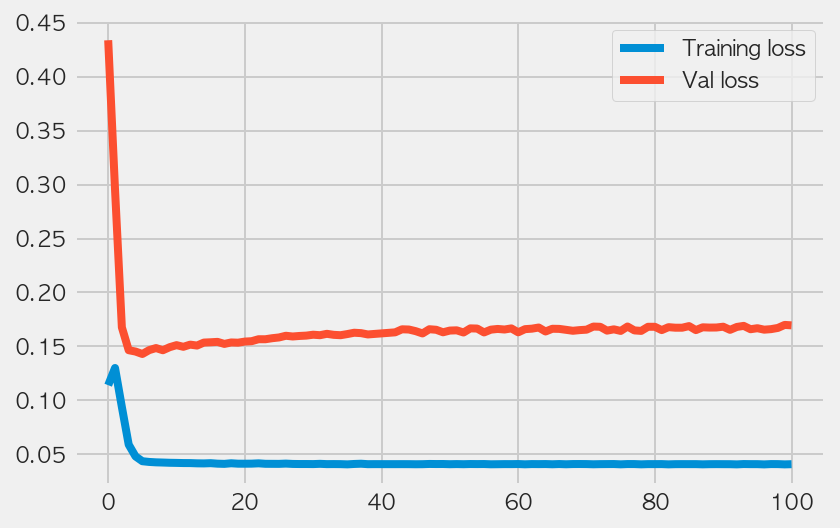

In [25]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()
plt.show()

## 예측

### One - Step 예측 

거 데이터를 활용해 한 단위 앞만 예측하는 방법

In [26]:
pred_dataset = X_test

with torch.no_grad() :
    preds = []
    for _ in range(len(pred_dataset)) :
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_],0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

현재 스케일링 된 y_test를 되돌려 주기 위해 아래 산식 이용  


$x = x_{scaled} * (x_{max} - x_{min}) + x_{min}$


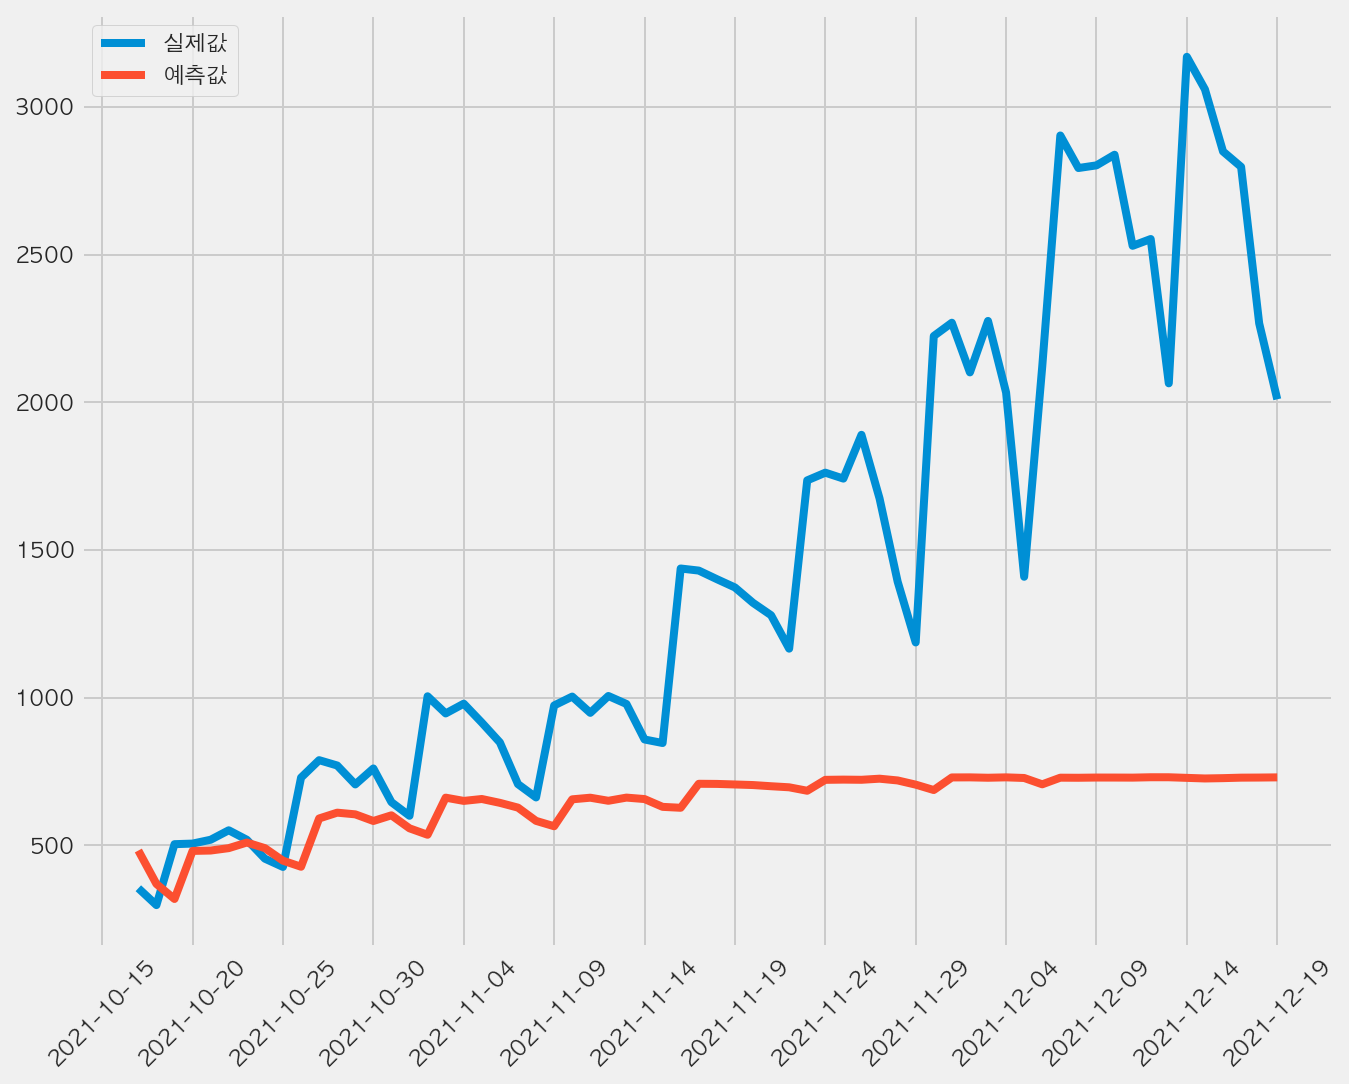

In [27]:
fig , ax = plt.subplots(figsize = (10,8))

ax.plot(time_series_data.index[-len(y_test):], np.array(y_test) * MAX, label='실제값')
ax.plot(time_series_data.index[-len(preds):], np.array(preds) * MAX, label='예측값')
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
plt.legend()
plt.show()

예측이 제대로 이루어지지 않고 있음 

In [28]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [29]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

846.7802211204544

시험 데이터에 대한 예측값이 평균적으로 실제값과 818명 정도 차이를 지니고 있음 

## CNN-LSTM

시계열에서는 1D CNN 사용, 1D CNN 활용 시 변수간의 지엽적인 특징을 추출할 수 있음

In [30]:
class CovidPredictor(nn.Module) :
    def __init__ (self, n_features , n_hidden, seq_len, n_layers) :
        super (CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride =1) 
        self.lstm = nn.LSTM( 
        input_size = n_features,
        hidden_size= n_hidden,
        num_layers = n_layers
        )
        
        self.linear = nn.Linear(in_features= n_hidden, out_features= 1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

### 모델 학습 

In [31]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() 
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): # sample 별 hidden state reset을 해줘야 함 

            model.reset_hidden_state()

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() #seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [32]:
model = CovidPredictor(
    n_features=1,
    n_hidden=5,
    seq_len=seq_length,
    n_layers=1
)

In [33]:
print(model)

CovidPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(1, 5)
  (linear): Linear(in_features=5, out_features=1, bias=True)
)


In [34]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.08896102225030643 val loss: 0.4349936544895172
Epoch 10 train loss: 0.041288347445472544 val loss: 0.18160369992256165
Epoch 20 train loss: 0.041069199274507584 val loss: 0.17483188211917877
Epoch 30 train loss: 0.04092690494397412 val loss: 0.17644527554512024
Epoch 40 train loss: 0.04097351605319252 val loss: 0.17670688033103943
Epoch 50 train loss: 0.04059311812016524 val loss: 0.17498265206813812
Epoch 60 train loss: 0.04078591751623089 val loss: 0.17303690314292908
Epoch 70 train loss: 0.04119627531608677 val loss: 0.1726493537425995
Epoch 80 train loss: 0.04045928930845333 val loss: 0.17318077385425568
Epoch 90 train loss: 0.040724681050741215 val loss: 0.17160721123218536


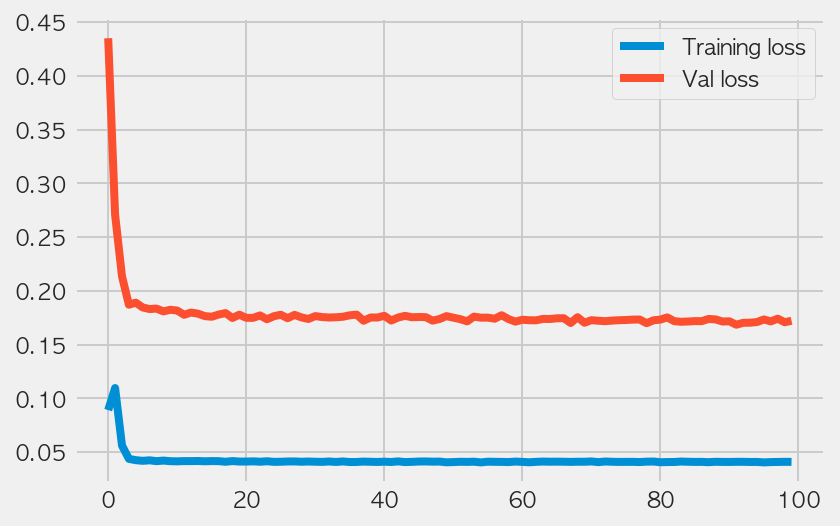

In [35]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()
plt.show()

### 예측 

In [36]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

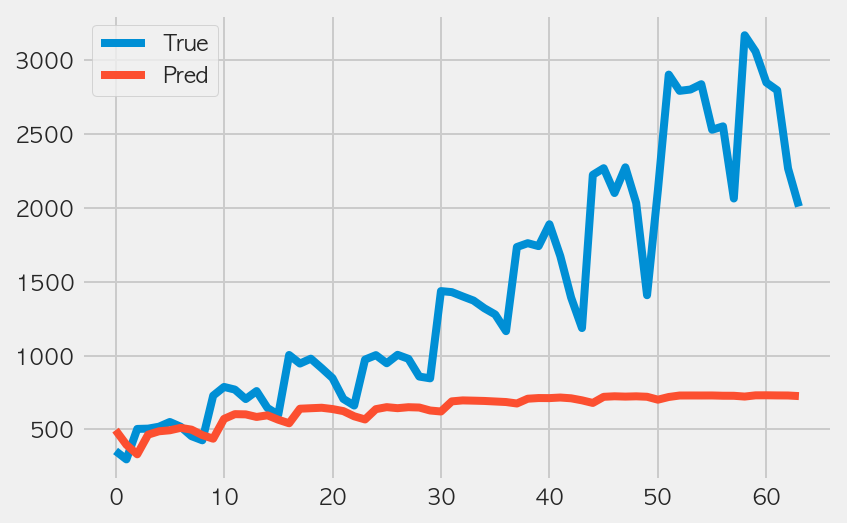

In [37]:
plt.plot(np.array(y_test)*MAX, label = 'True')
plt.plot(np.array(preds)*MAX, label = 'Pred')
plt.legend()
plt.show()

In [38]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [39]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

848.4725168313598

시계열(Time Series) 예측은 데이터가 많지 않으면 정확도가 떨어지기 때문에 예측에서 문제가 발생